In [3]:
from transformers import EsmTokenizer, EsmModel
from Bio import SeqIO
import torch

from sequence_id_trimming import sequence_list

# Load the tokenizer and model from Hugging Face
model_name = "facebook/esm2_t33_650M_UR50D"
tokenizer = EsmTokenizer.from_pretrained(model_name)
model = EsmModel.from_pretrained(model_name)

# Set the model to evaluation mode
model.eval()

# Load sequences from the provided FASTA file
sequences = sequence_list("test_Prodigalheaders.fasta")[:10] # test with of 10 scaffolds

# Tokenize sequences with the Hugging Face tokenizer
batch_size = 16  # Adjust as necessary
LAYER_OF_INTEREST = 33  # Set to the layer you are interested in

# Function to process a batch
def process_batch(batch_data):
    """
    batch_data: list of (seq_id, seq_str) for one batch
    """
    batch_ids = [seq_id for seq_id, _ in batch_data]
    batch_strs = [seq_str for _, seq_str in batch_data]
    
    # Tokenize batch of sequences
    inputs = tokenizer(batch_strs, padding=True, truncation=True, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)
        # Extract the representations for the layer of interest
        embeddings = outputs.last_hidden_state

    # Mean pooling over the sequence length (excluding [CLS] and [EOS] tokens)
    mean_embeddings = embeddings.mean(dim=1)

    return batch_ids, mean_embeddings

# Loop over the sequences in batches
batch_size = 16
current_batch = []
start_idx = 0
for seq_tuple in sequences:
    current_batch.append(seq_tuple)
    if len(current_batch) == batch_size:
        batch_ids, mean_embeddings = process_batch(current_batch)

        print(f"Batch IDs: {batch_ids}")  # Prints the sequence IDs
        print(f"Mean Embeddings (first 5): {mean_embeddings[:5]}")  # Prints first 5 embeddings from the batch
        
        start_idx += len(current_batch)
        current_batch = []

# Handle any leftover sequences
if current_batch:
    batch_ids, mean_embeddings = process_batch(current_batch)
    # Print out some results for leftover sequences
    print(f"Batch IDs: {batch_ids}")
    print(f"Mean Embeddings (first 5): {mean_embeddings[:5]}")

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Batch IDs: ['D4993_C5_H2-scaffold_435533_2', 'D4993_C5_H2-scaffold_167195_15', 'D4994_C39_H1-scaffold_41868_6', 'D4993_C5_H2-scaffold_239627_4', 'D4993_C5_LG-scaffold_15808_7', 'D4993_C5_H1-scaffold_413393_20', 'D4994_C39_H1-scaffold_756742_6', 'D4994_C39_H2-scaffold_54269_1', 'D4998_C1112_H3-scaffold_67784_11', 'D4998_C1112_H2-scaffold_9112_4']
Mean Embeddings (first 5): tensor([[ 0.0568,  0.0291,  0.0714,  ..., -0.2584,  0.1014, -0.0750],
        [ 0.0902, -0.0199,  0.0157,  ..., -0.0812,  0.0196,  0.1051],
        [ 0.0598, -0.0014, -0.0208,  ..., -0.0391, -0.0453, -0.0360],
        [ 0.1265, -0.0259, -0.0384,  ..., -0.0925, -0.1005,  0.0455],
        [ 0.0239,  0.0699, -0.0379,  ..., -0.1562, -0.0442, -0.0403]])


In [5]:
#To remove the conflicting h5py file
sys.path = [p for p in sys.path if not p.startswith("/opt")]
#IF above doesn't fix import error, uncomment the following
#sys.path.insert(0,"/work2/10113/ivysfan/frontera/anaconda3/envs/esm_embed")

In [6]:
from transformers import EsmTokenizer, EsmModel
from Bio import SeqIO
import torch
import h5py

# Define the function to extract sequences from a FASTA file
def sequence_list(fasta_file):
    sequences = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        sequences.append((record.id, str(record.seq)))
    return sequences

# Load the tokenizer and model from Hugging Face
model_name = "facebook/esm2_t33_650M_UR50D"
tokenizer = EsmTokenizer.from_pretrained(model_name)
model = EsmModel.from_pretrained(model_name)

# Set the model to evaluation mode
model.eval()

# extract the first 10 sequences only --> MODIFY
sequences = sequence_list("test_Prodigalheaders.fasta")[:10]

max_length = 1024 # maximum length for truncation

# Create an HDF5 file to store the embeddings
h5_filename = "esm_embeddings.h5"
hf = h5py.File(h5_filename, "w")

# Create datasets to store the embeddings and sequence IDs
batch_size = 16
dim = 1280  # ESM2 650M model has 1280-dimensional embeddings
N = len(sequences)

# Create the embeddings dataset with compression
embeddings_ds = hf.create_dataset("embeddings", (N, dim), dtype="float32", compression="gzip") # shape of embeddings: (N, dim/embedding size)
seq_ids_ds = hf.create_dataset("sequence_ids", (N,), dtype=h5py.special_dtype(vlen=str)) # store with variable length

# Function to process a batch
def process_batch(batch_data, start_idx):
    """
    batch_data: list of (seq_id, seq_str) for one batch
    start_idx: starting index in HDF5 where results should be stored
    """
    batch_ids = [seq_id for seq_id, _ in batch_data]
    batch_strs = [seq_str for _, seq_str in batch_data]
    
    # Tokenize batch of sequences with truncation and padding
    inputs = tokenizer(batch_strs, padding=True, truncation=True, max_length=max_length, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)
        # Extract the representations for the layer of interest (last layer)
        embeddings = outputs.last_hidden_state

    # Mean pooling over the sequence length (excluding [CLS] and [EOS] tokens)
    mean_embeddings = embeddings.mean(dim=1)

    # Write to the HDF5 datasets
    embeddings_ds[start_idx:start_idx+len(batch_data)] = mean_embeddings.cpu().numpy()
    seq_ids_ds[start_idx:start_idx+len(batch_data)] = batch_ids

# Loop over the sequences in batches
current_batch = []
start_idx = 0
for seq_tuple in sequences:
    current_batch.append(seq_tuple)
    if len(current_batch) == batch_size:
        process_batch(current_batch, start_idx)
        start_idx += len(current_batch)
        current_batch = []

# Handle any leftover sequences
if current_batch:
    process_batch(current_batch, start_idx)

# Close the HDF5 file
hf.close()

print(f"Done! Mean embeddings saved to {h5_filename}")

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Done! Mean embeddings saved to esm_embeddings.h5


In [11]:
# 1 - display (truncated) datasets in h5py file
import pandas as pd
import h5py

embedding_file = 'esm_embeddings.h5'

with h5py.File(embedding_file, 'r') as h5f:
    embeddings = h5f["embeddings"][:] # shape: (N, 1280)
    sequence_ids = h5f["sequence_ids"][:] # shape: (N, )
    sequence_ids = [sid.decode("utf-8") if isinstance(sid, bytes) else sid for sid in sequence_ids]
    num_display_dims = 5 # change to see different dimensions
    embeddings = embeddings[:, :num_display_dims]
    df = pd.DataFrame(embeddings, index=sequence_ids,
                  columns=[f"dim_{i+1}" for i in range(num_display_dims)])
    print(df)

                                     dim_1     dim_2     dim_3     dim_4  \
D4993_C5_H2-scaffold_435533_2     0.056774  0.029059  0.071382  0.060678   
D4993_C5_H2-scaffold_167195_15    0.090180 -0.019881  0.015685  0.052156   
D4994_C39_H1-scaffold_41868_6     0.059753 -0.001416 -0.020794  0.051046   
D4993_C5_H2-scaffold_239627_4     0.126537 -0.025857 -0.038386  0.052240   
D4993_C5_LG-scaffold_15808_7      0.023860  0.069895 -0.037914  0.057688   
D4993_C5_H1-scaffold_413393_20    0.085090  0.032749  0.045770  0.044478   
D4994_C39_H1-scaffold_756742_6    0.061175  0.148710  0.059470  0.020862   
D4994_C39_H2-scaffold_54269_1     0.030785 -0.126887  0.017017  0.038238   
D4998_C1112_H3-scaffold_67784_11  0.125695  0.027052  0.011855 -0.013578   
D4998_C1112_H2-scaffold_9112_4    0.051801 -0.037201  0.028031 -0.009349   

                                     dim_5  
D4993_C5_H2-scaffold_435533_2     0.014110  
D4993_C5_H2-scaffold_167195_15   -0.087454  
D4994_C39_H1-scaffold_41868_

In [21]:
# 2 - compute pairwise cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
import h5py

def compute_cosine_similarity_matrix(h5_filename):
    # Load the data from HDF5 file
    with h5py.File(h5_filename, 'r') as hf:
        seq_ids = list(hf['sequence_ids'][:])
        embeddings = hf['embeddings'][:]
        
    # Method 1 - Compute cosine similarity
    cosine_sim_matrix = cosine_similarity(embeddings)
    
    # 2.1 - Normalize embeddings
    # norm_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    # 2.2 - Compute cosine similarity matrix
    # cosine_sim_matrix = np.dot(norm_embeddings, norm_embeddings.T)
    
    return seq_ids, cosine_sim_matrix

seq_ids, cosine_sim_matrix = compute_cosine_similarity_matrix("esm_embeddings.h5")

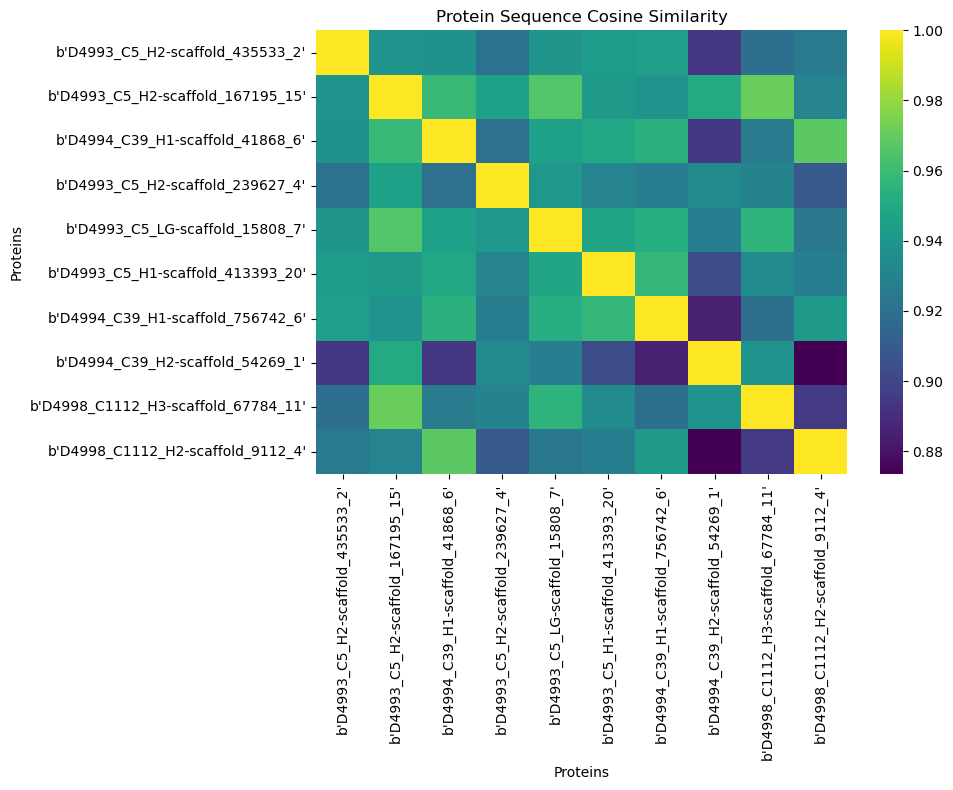

In [14]:
# 2.2 - plot cosine similarity matrix to visualize
import matplotlib.pyplot as plt
import seaborn as sns

def plot_similarity_heatmap(seq_ids, cosine_sim_matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cosine_sim_matrix, xticklabels=seq_ids, yticklabels=seq_ids, cmap='viridis')
    plt.title("Protein Sequence Cosine Similarity")
    plt.xlabel("Proteins")
    plt.ylabel("Proteins")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

subset_size = 20
sim_submatrix = cosine_sim_matrix[:subset_size, :subset_size]

# plot a part of matrix
plot_similarity_heatmap(seq_ids, sim_submatrix)

# plot entire matrix
# plot_similarity_heatmap(seq_ids, cosine_sim_matrix)

In [ ]:
# use consine similarity to cluster protein sequences?
# or graph using cosine similarity as edges?
# threshold?

# use cosine similarity for operon clustering
# test with different clustering algorithms

# DBSCAN

# hierarchical (ward)

In [16]:
# 3 - build graph to visualize cosine similarity: node = sequence_id, edge = cosine similarity
import networkx as nx

def build_graph(seq_ids, consine_sim_matrix, threshold=0.9):
    G = nx.Graph()

    # add nodes
    G.add_nodes_from(seq_ids)
    
    # filter edges above threshold
    N = len(seq_ids)
    edges = []
    for i in range(N):
        for j in range(i + 1, N):
            sim = cosine_sim_matrix[i][j]
            if sim >= threshold:
                edge = (seq_ids[i], seq_ids[j], {"weight": sim})
                edges.append(edge)

    # add edges
    G.add_edges_from(edges)

    return G

G = build_graph(seq_ids, cosine_sim_matrix, threshold=0.9)

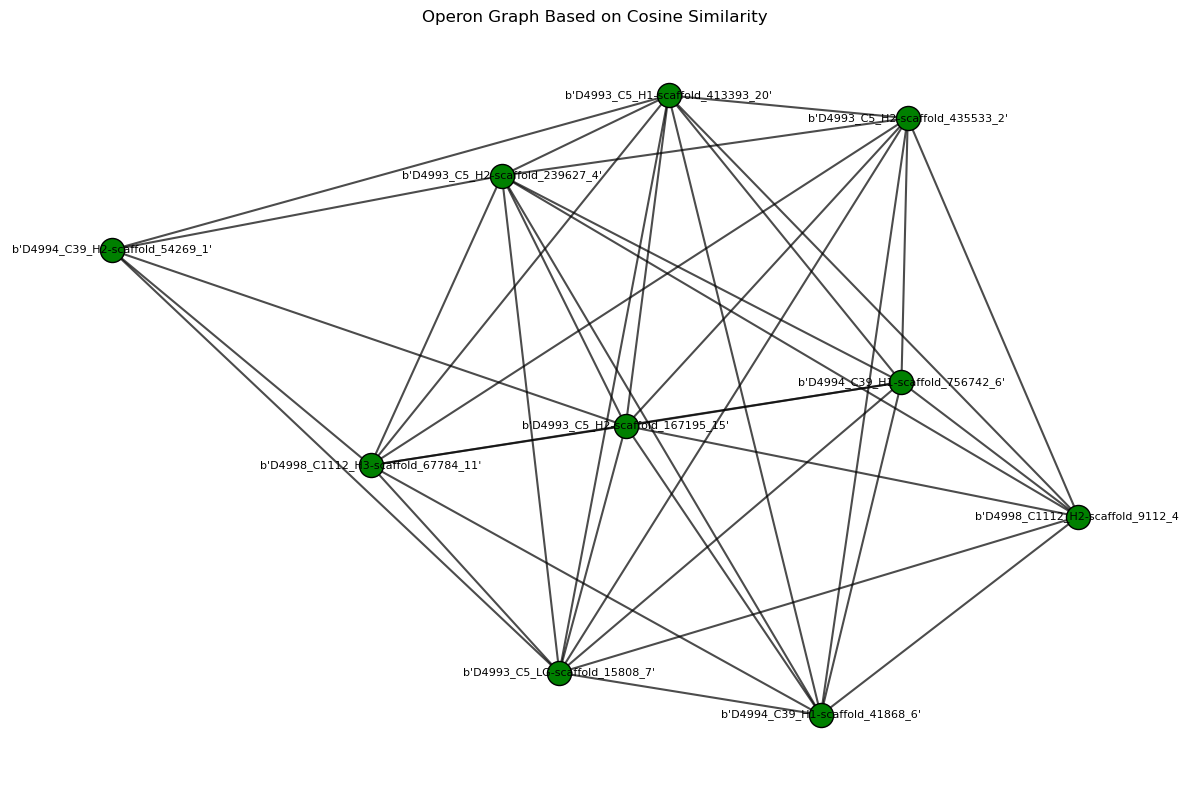

In [20]:
# 4 - visualize consine similarity graph
def visualize_graph(G, node_size=300):
    plt.figure(figsize=(12, 8))
    
    pos = nx.spring_layout(G, seed=42)
    # pos = nx.kamada_kawai_layout(G, seed=42)

    # draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='green', edgecolors='black')

    # draw edges
    nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.7)

    # draw labels
    nx.draw_networkx_labels(G, pos, font_size=8, font_family="sans-serif")

    plt.title("Operon Graph Based on Cosine Similarity")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize_graph(G)

## > Troubleshooting library importing

In [11]:
import sys
print(sys.executable)
print(sys.path)
path=sys.path

print(sys.path)

print(sys.path)

/work2/10113/ivysfan/frontera/anaconda3/bin/python
['/work2/10113/ivysfan/frontera/anaconda3/envs/esm_embed', '/work2/10113/ivysfan/frontera/anaconda3/envs/esm_embed', '/home1/10113/ivysfan/ESM', '', '/work2/10113/ivysfan/frontera/anaconda3/lib/python312.zip', '/work2/10113/ivysfan/frontera/anaconda3/lib/python3.12', '/work2/10113/ivysfan/frontera/anaconda3/lib/python3.12/lib-dynload', '/home1/10113/ivysfan/.local/lib/python3.12/site-packages', '/work2/10113/ivysfan/frontera/anaconda3/lib/python3.12/site-packages', '/tmp/tmpd3da9uew', '/work2/10113/ivysfan/frontera/anaconda3/envs/esm_embed']
['/work2/10113/ivysfan/frontera/anaconda3/envs/esm_embed', '/work2/10113/ivysfan/frontera/anaconda3/envs/esm_embed', '/work2/10113/ivysfan/frontera/anaconda3/envs/esm_embed', '/home1/10113/ivysfan/ESM', '', '/work2/10113/ivysfan/frontera/anaconda3/lib/python312.zip', '/work2/10113/ivysfan/frontera/anaconda3/lib/python3.12', '/work2/10113/ivysfan/frontera/anaconda3/lib/python3.12/lib-dynload', '/hom

In [12]:
import h5py
print(h5py.__file__)

/home1/10113/ivysfan/.local/lib/python3.12/site-packages/h5py/__init__.py


In [7]:
import torch
import esm
import numpy as np
# import h5py

from sequence_id_trimming import name_trimming, sequence_tuple